In [1]:
from astropy.time import Time
import requests
import numpy as np

T0_isot = "2022-10-09T13:17:00"
T0_ijd = Time(T0_isot).mjd - 51544


acslc_r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/ACS/{T0_ijd}/40000")
import pandas as pd
import io

acslc = pd.read_csv(io.StringIO(acslc_r.text), skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)
acslc


from matplotlib import pylab as plt

In [2]:
acslc_r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/ACS/{T0_ijd}/40000")


In [3]:
hklc = {}


In [5]:
# oda:version "v0.1.4"

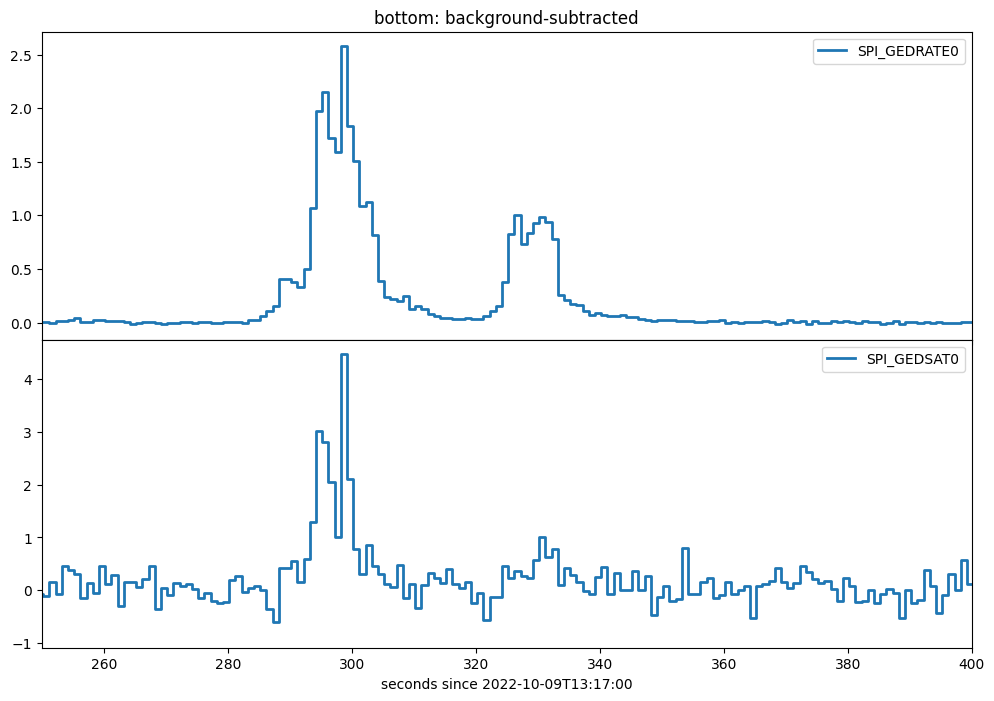

: 

In [36]:

def gethklc(n):
    r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/{n}/{T0_ijd}/4000")
    return pd.read_csv(io.StringIO(r.text), skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)

# IBIS_VETO
for n in ['SPI_VETOGATE', 'SPI_VETONONSAT', 'SPI_GEDRATE0', 'SPI_GEDSAT0', 'SPI_VETOSAT']: # + ['FEE{i}' for i in range(1, 92)]:
    print("fetching", n)

    if n not in hklc:
        hklc[n] = gethklc(n)
    
    


groups = [
    # [
    #     'VETOSAT', 
    #     'SPI_VETOGATE', 
    #     'SPI_VETONONSAT'
    # ],
    ['GEDRATE0'],
    ['GEDSAT0']    
]

f, axes = plt.subplots(len(groups), 1, figsize=(12, 8), sharex=True)


for l, lc in hklc.items():
    if len(lc.t) < 10: continue

    t_rel_s = (lc.t - T0_ijd)*24*3600
    bkg = np.nanmean(lc.c[t_rel_s < 200])
    
    # axes[0].plot(
    #     (lc.t - T0_ijd)*24*3600,
    #     lc.c,
    #     # lc.c**0.5,
    #     # xerr=1 + np.array(lc.t)*0,
    #     lw=2,
    #     # ls="",
    #     # label=l,
    # )


    for ax, group in zip(axes, groups):
        if any([k in l for k in group]):
            
            ax.step(
                t_rel_s,
                (lc.c - bkg)/np.max((lc.c - bkg)[t_rel_s > 320]),
                # lc.c**0.5,
                # xerr=1 + np.array(lc.t)*0,
                lw=2,
                # ls="",
                label=l,
            )

    # break


for ax in axes:
    ax.legend()

plt.sca(axes[-1])

plt.subplots_adjust(hspace=0)


plt.xlim([250, 400])
axes[-1].set_xlabel(f"seconds since {T0_isot}")
axes[0].set_title("bottom: background-subtracted")
plt.savefig("many_hk_rates.pdf")

In [7]:
def get_selected_region(t1, t2):
    m = acslc.t > T0_ijd + t1/24
    m &= acslc.t < T0_ijd + t2/24
    return m

bkg = np.mean(acslc.c[acslc.t<T0_ijd - 1000./24/3600])




def rebin(x, n):
    N = int(len(x)/n)
    return np.array(x[:N*n]).reshape((N, n)).sum(1)


from scipy.optimize import curve_fit

F = lambda x,a,b,c,d: a+b*x+c*x**2+d*x**3
n = 1000
T_rel_hr = (rebin(acslc.t, n)/n - T0_ijd)*24
m = T_rel_hr < -1
m |= T_rel_hr > 2

curves = []

for (t1, t2) in [
                (-1, 4),
                (-1, 2),
                (-1, 3),
                (-2, 4),
            ]:
    for (bt1, bt2) in [
            (-2, 5),
            (-6, 6),
            (-5, 5),
            (-3, 4),
            (-2, 4),
            (-2, 3.5),
            (-2, 7),
            (-3, 7),
            ]:

        _m1 = (T_rel_hr > bt1) & (T_rel_hr < t1)
        _m2 = (T_rel_hr > t2) & (T_rel_hr < bt2)
        _m = _m1 | _m2

        print(bt1, bt2, t1, t2, sum(_m))

        if sum(_m1) > 0 and sum(_m2) > 0:

            curves.append(curve_fit(
                F,
                T_rel_hr[_m],
                (rebin(acslc.c, n)/n - bkg)[_m]
                # (rebin(acslc.c, n)/n - bkg)[m]
                ))




-2 5 -1 4 144
-6 6 -1 4 504
-5 5 -1 4 360
-3 4 -1 4 144
-2 4 -1 4 72
-2 3.5 -1 4 72
-2 7 -1 4 288
-3 7 -1 4 360
-2 5 -1 2 288
-6 6 -1 2 648
-5 5 -1 2 504
-3 4 -1 2 288
-2 4 -1 2 216
-2 3.5 -1 2 180
-2 7 -1 2 432
-3 7 -1 2 504
-2 5 -1 3 216
-6 6 -1 3 576
-5 5 -1 3 432
-3 4 -1 3 216
-2 4 -1 3 144
-2 3.5 -1 3 108
-2 7 -1 3 360
-3 7 -1 3 432
-2 5 -2 4 72
-6 6 -2 4 432
-5 5 -2 4 288
-3 4 -2 4 72
-2 4 -2 4 0
-2 3.5 -2 4 0
-2 7 -2 4 216
-3 7 -2 4 288


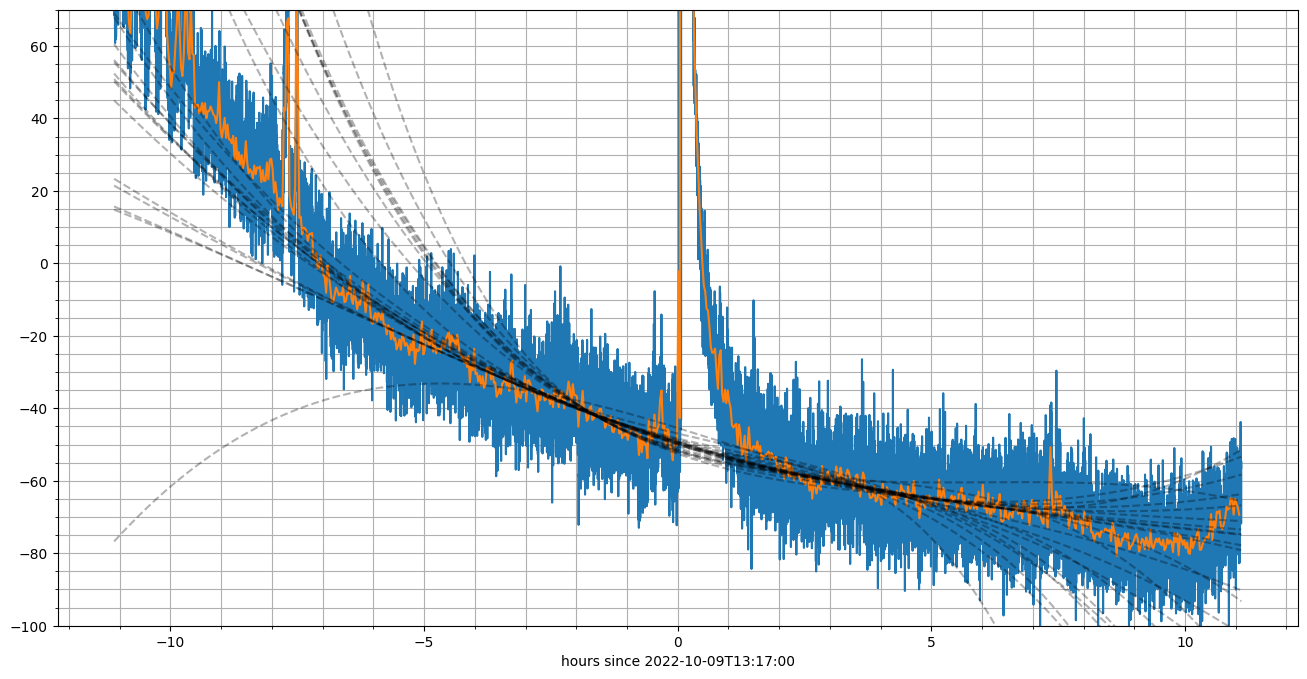

In [8]:
plt.figure(figsize=(16,8))


for n in 100, 2000:

    plt.plot(
        (rebin(acslc.t, n)/n - T0_ijd)*24,
        rebin(acslc.c, n)/n - bkg, # - F((rebin(acslc.t, n)/n - T0_ijd)*24, *curve[0])
    )

# plt.plot(
#     T[m],
#     (rebin(acslc.c, n)/n - bkg)[m]
# )

ccm = []

for curve in curves:
    curve_counts = F((acslc.t - T0_ijd)*24, *curve[0])
    plt.plot(
        (acslc.t - T0_ijd)*24,
        curve_counts,
        ls="--",
        color='k',
        alpha=0.3
    )
    ccm.append(curve_counts)

plt.grid(which='both')

plt.ylim([-100,70])
plt.minorticks_on()

plt.xlabel(f'hours since {T0_isot}')
plt.savefig("acsbkg.pdf")

In [9]:
acslc['bkg_max'] = np.stack(ccm).max(0)
acslc['bkg_min'] = np.stack(ccm).min(0)
acslc['bkg_mean'] = np.stack(ccm).mean(0)


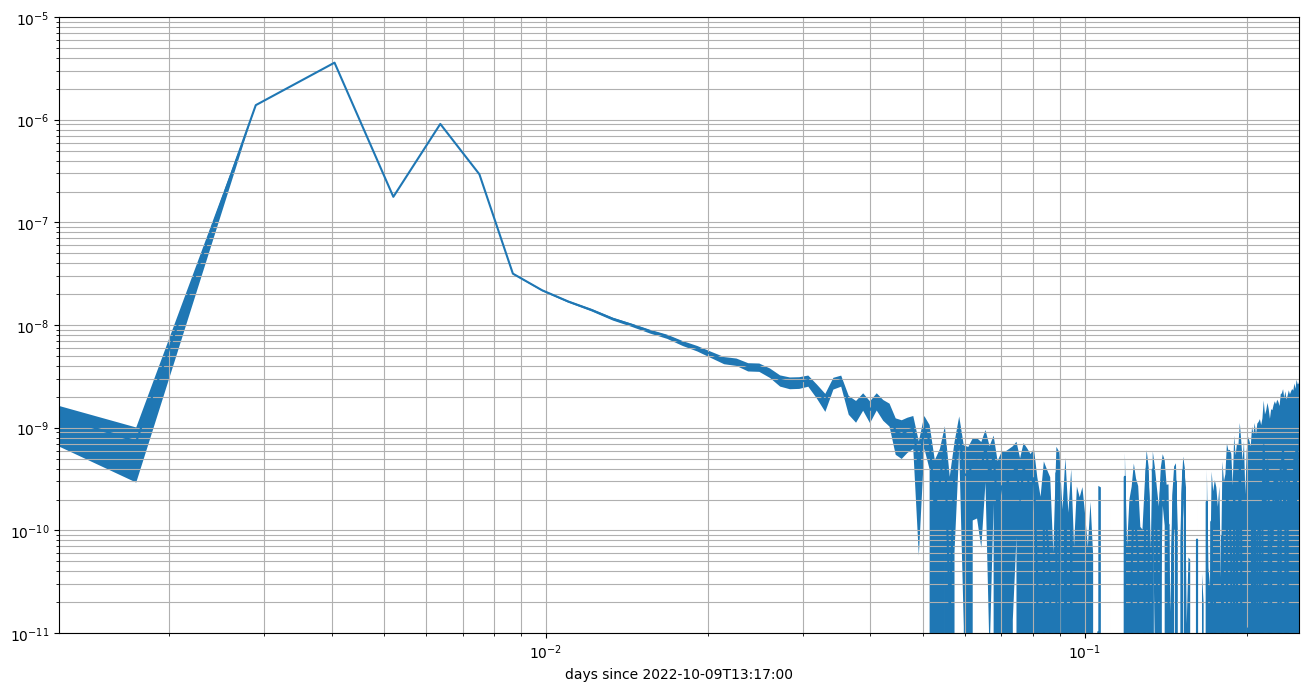

In [10]:
plt.figure(figsize=(16,8))

cts_to_fluence = 1e-10

# for n in 100, 2000:
for n in 2000,:

    plt.plot(
        (rebin(acslc.t, n)/n - T0_ijd),
        rebin(acslc.c - acslc.bkg_mean - bkg, n)/n * cts_to_fluence,
    )

    plt.fill_between(
        (rebin(acslc.t, n)/n - T0_ijd),
        rebin(acslc.c - acslc.bkg_max - bkg, n)/n * cts_to_fluence,
        rebin(acslc.c - acslc.bkg_min - bkg, n)/n * cts_to_fluence,
    )

plt.grid(which='both')

plt.ylim([1e-11,  1e-5])
# plt.ylim([-40 * cts_to_fluence ,70 * cts_to_fluence])
plt.xlim([0.03/24, 6/24])

plt.loglog()

plt.minorticks_on()

plt.xlabel(f'days since {T0_isot}')
plt.savefig("acsnobkg.pdf")

acslc.to_csv("acslc.csv")

# TODO: check compton rate

In [11]:
acsbkg_pdf = "acsbkg.pdf"
acslc_csv = "acslc.csv"
many_hk_rates_pdf = "many_hk_rates.pdf"